# Learning Discrete-Time Estimation and Control with Transformers: Baselines

In [44]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T =  150 # 250 # how long to simulate the trajectory
CUT = 5 # cutoff the first 5 elements of the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = 2
num_traj_train = 200 # 100 # number of trajectories to simulate
num_traj_test = 20 # number of trajectories to simulate
num_traj = num_traj_train + num_traj_test

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories that follow a fixed path on the unit circle

In [45]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
# B = np.zeros(shape=(state_dim, input_dim)) # ignore inputs for now
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state

In [46]:
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj = np.zeros(shape=(num_traj, T, state_dim))
meas = np.zeros(shape=(num_traj, T, obs_dim))

for traj_index in range(num_traj):
    x = x0
    for i in range(T):
        u_t = u_seq[traj_index, i]
        w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
        x = A @ x + w_t + B @ u_t # inputs
        v_t = rng.multivariate_normal(mean=np.zeros(obs_dim), cov=R) # sensor noise
        y = C @ x + v_t
        traj[traj_index, i] = x
        meas[traj_index, i] = y

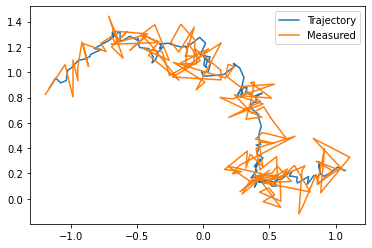

In [57]:
# plot a sample trajectory and noisy measurements
ind_to_vis = 119

plt.figure()
#fig, ax = plt.subplots()
linetraj = plt.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:, 1], label='Trajectory')
linemeas = plt.plot(meas[ind_to_vis, CUT:, 0], meas[ind_to_vis, CUT:, 1], label='Measured')

plt.legend()
plt.show()

## 1. Kalman Filtering using known A, B to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [58]:
err_fltr = 0

for i in range(num_traj_train, num_traj): # only the test trajs
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    fltr = kinematics_forward.simulate(meas[i], u_seq[i])

    err_fltr += np.linalg.norm(fltr[CUT:,:] - traj[i,CUT:,:])**2
    
    if i == ind_to_vis:
        plt.figure()
        fig, ax = plt.subplots()
        linetraj, = ax.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:,1], label="Trajectory")
        linefltr, = ax.plot(fltr[CUT:, 0], fltr[CUT:,1], label="Filtered", color='g')
        plt.legend()
        plt.show()

print("Average Squared Error:", err_fltr / num_traj_test / T)

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Average Squared Error: 0.00545470627864479


### 1b. Kalman Filter with pure steady state gains

In [59]:
err_fltr_ss = 0

for i in range(num_traj_train, num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    fltr_ss = kinematics_forward.simulate(meas[i], u_seq[i])

    if i == ind_to_vis:
        plt.figure()
        fig, ax = plt.subplots()
        linetraj, = ax.plot(traj[i,CUT:,0], traj[i,CUT:,1], label="Trajectory")
        #linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
        linefltr, = ax.plot(fltr_ss[CUT:,0], fltr_ss[CUT:,1], label="Filtered", color='g')
        plt.legend()
        plt.show()

    err_fltr_ss += np.linalg.norm(fltr_ss[CUT:,:] - traj[i,CUT:,:])**2

print("Average Squared Error", err_fltr_ss / num_traj_test / T)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Average Squared Error 0.005461203283844485


## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep

<Figure size 432x288 with 0 Axes>

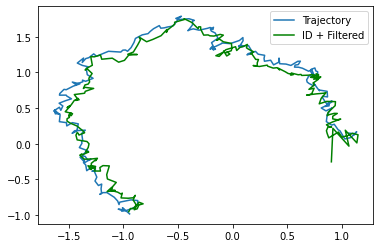

Average Squared Error 0.017678075699142745


In [7]:
err_id_fltr = 0

for i in range(num_traj_train, num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state

    if i == ind_to_vis:
        plt.figure()
        fig, ax = plt.subplots()
        linetraj, = ax.plot(traj[i,CUT:,0], traj[i,CUT:,1], label="Trajectory")
        linefltr, = ax.plot(id_fltr[CUT:,0], id_fltr[CUT:,1], label="ID + Filtered", color='g')
        plt.legend()
        plt.show()

    err_id_fltr += np.linalg.norm(id_fltr[CUT:,:] - traj[i,CUT:,:])**2
print("Average Squared Error", err_id_fltr / num_traj_test / T)

## 2b Kalman filter for each timestep simulated from the start

Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

<Figure size 432x288 with 0 Axes>

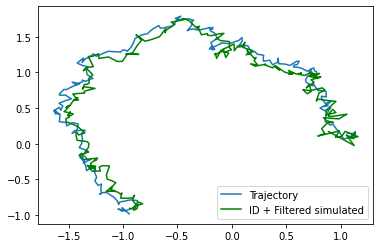

Average Squared Error 0.01863298925432532


In [8]:
err_id_fltr_sim = 0

for i in range(num_traj_train, num_traj):
    id_fltr_sim = np.zeros(shape=(T,state_dim))
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_fltr_sim[t] = kinematics.simulate(meas[i][:t], u_seq[i][:t])[-1]

    err_id_fltr_sim += np.linalg.norm(id_fltr_sim[CUT:, :] - traj[i,CUT:, :])**2

    if i == ind_to_vis:
        plt.figure()
        fig, ax = plt.subplots()
        linetraj, = ax.plot(traj[i,CUT:,0], traj[i,CUT:,1], label="Trajectory") # cut out first point since it starts at the origin
        #linemeas, = ax.plot(meas[CUT:,0], meas[CUT:,1], label="Measured")
        linefltr, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated", color='g')
        plt.legend()
        plt.show()

print("Average Squared Error", err_id_fltr_sim / num_traj_test / T)

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

Iteration 1000 : Loss 4.74186150128924
Iteration 2000 : Loss 4.166877472960879
Iteration 3000 : Loss 3.949510062748068
Iteration 4000 : Loss 3.8648730740020363
Iteration 5000 : Loss 3.80825264849916
Iteration 6000 : Loss 3.751266351812848
Iteration 7000 : Loss 3.683750611697895
Iteration 8000 : Loss 3.6103867676637833
Iteration 9000 : Loss 3.5489928153557506
Iteration 10000 : Loss 3.5078655239669247
Iteration 11000 : Loss 3.484670732831727
Iteration 12000 : Loss 3.4745898102030712
Iteration 13000 : Loss 3.4717687372171326
Iteration 14000 : Loss 3.4713896756806784


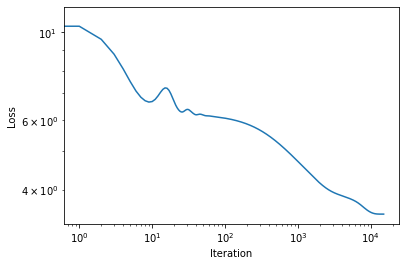

<Figure size 432x288 with 0 Axes>

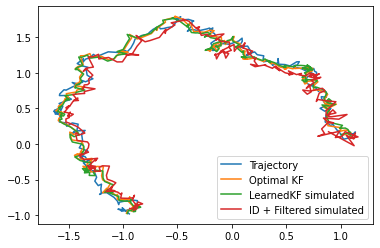

Average Squared Errors 0.005479705393861925


In [9]:
err_learned_kf = 0
learned_kfs = []
if True:
    i = 119
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

    if i == ind_to_vis:
        plt.figure()
        fig, ax = plt.subplots()
        linetraj, = ax.plot(traj[i,CUT:,0], traj[i,CUT:,1], label="Trajectory")
        linetrueKF, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Optimal KF")
        linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated")
        lineopt, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated")
        plt.legend()
        plt.show()

print("Average Squared Errors", err_learned_kf / T) #num_traj_test / T)

<Figure size 432x288 with 0 Axes>

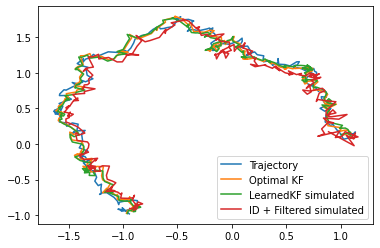

Average Squared Errors 0.005479705393861925


In [10]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[i,CUT:,0], traj[i,CUT:,1], label="Trajectory")
linetrueKF, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Optimal KF")
linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated")
lineopt, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated")
plt.legend()
plt.show()

print("Average Squared Errors", err_learned_kf / T) # / num_traj_test)

In [17]:
# learned_kf = learned_kfs[0]
# true_kf = KFilter(A, B, C, Q, R, state=x0)
# true_kf.run_till_ss()
# print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
# print("Aprime learned is", learned_kf.Aprime)
# print("Bprime true is", B)
# print("Bprime learned is", learned_kf.Bprime)
# print("Gprime true is", A @ true_kf.K)
# print("Gprime learned is", learned_kf.Gprime)
# print("Cprime true is", C)
# print("Cprime learned is", learned_kf.Cprime)

# Now, let's see if a transformer can learn the dynamics and filter the position

In [19]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 36 # use 36-dimensional embedding for now
batch_size = 10

In [20]:
# Training Data
indices_train = np.arange(num_traj_train)
np.random.shuffle(indices_train)

# The input to the model will be a concatenation of the current measured state and the "u" input at this timestep
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
true_positions_train = torch.from_numpy(traj)[indices_train,:,:]


# Test Data
indices_test = np.arange(num_traj_train, num_traj)
traj_test = traj[indices_test,:,:]
meas_test = meas[indices_test,:,:]
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj)[indices_test,:,:]

## GPT-style: Transformer Decoder only for Autoregressive generation

In [27]:
num_epochs = 200

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=state_dim,
                 n_layers=3, n_heads=6, d_filter=256, dropout=None)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]  #TRYING TO HIT NOISY DATA

        decoder_output = gpt_model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)
        loss = loss_func(decoder_output, target_sequence_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 551.6083473496099
Epoch 1 : Loss 228.8414483354601
Epoch 2 : Loss 171.40153044280692
Epoch 3 : Loss 132.37796733143435
Epoch 4 : Loss 125.93568165209852


KeyboardInterrupt: 

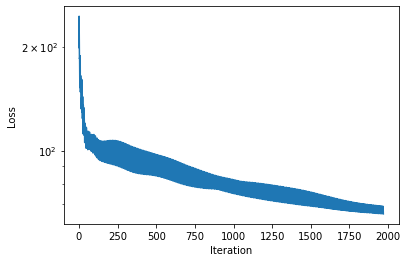

In [22]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

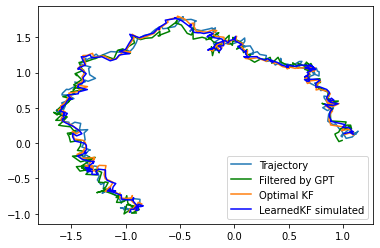

Average Squared Error 0.011605447956187658


In [26]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
ind_to_vis = 19 # 0 through 19
rand_ind = 12

filtered = gpt_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
#linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by GPT', color='g')

linetrueKF, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Optimal KF")
linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated", color='b')

plt.legend()
plt.show()

#print('Average Squared Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
#print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)

In [29]:
# print(np.linalg.norm(filtered[1] - traj_test[2])**2 / num_traj_test / T)

## Least-Squares: Fit a linear model that predicts true position from the noisy reading 
(This is the baseline for BERT)

In [ ]:
LS_model = 

## BERT-style: Transformer Encoder only, fill in the blanks for the trajectory 

Note - we are taking advantage of the ground truth (TRUE TRAJECTORY) here! 

In [30]:
num_epochs = 100
p = 0.15 # probability of zeroing out a token

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, 
                n_layers=3, n_heads=6, d_filter=256, 
                dropout=None)
optimizer = torch.optim.Adam(bert_model.parameters())

loss_func = torch.nn.MSELoss(reduction='sum')
losses = []

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        # Randomly zero-out p% of the tokens in transformer_input_train - different for each batch each time
        # If we're trying to hit the true targets, DO NOT MASK!
        # mask = torch.bernoulli( (1-p) * torch.ones(size=(batch_size, T) ) )
        # mask = mask.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :] # * mask
        
     
        # NO! do NOT use a zero-mask. instead, your mask should be LEARNABLE! you should REPLACE tokens with the mask, NOT MULTIPLY!
        # FIX THIS
        
        # transformer_input_batch has shape [batch_size, seq_len, (obs_dim+input_dim)] 
        
        true_positions_batch = true_positions_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]        
        encoder_output = bert_model(transformer_input_batch, encoder_mask=None)

        loss = loss_func(encoder_output, true_positions_batch) #,target_sequences_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 576.2763881741749
Epoch 1 : Loss 228.5494200774964
Epoch 2 : Loss 134.42122520554605
Epoch 3 : Loss 82.33918296650342
Epoch 4 : Loss 64.66038923502407
Epoch 5 : Loss 56.32003616069896
Epoch 6 : Loss 51.73242918152996
Epoch 7 : Loss 48.58921541332194
Epoch 8 : Loss 46.69412644959475
Epoch 9 : Loss 45.42932101620199
Epoch 10 : Loss 44.43685839373799
Epoch 11 : Loss 43.59265842551806
Epoch 12 : Loss 42.916680515943234
Epoch 13 : Loss 42.327887581299166
Epoch 14 : Loss 41.816856134179694
Epoch 15 : Loss 41.38848218766902
Epoch 16 : Loss 40.99209969665263
Epoch 17 : Loss 40.618163473126465
Epoch 18 : Loss 40.27880360017504
Epoch 19 : Loss 39.958887507827825
Epoch 20 : Loss 39.66769972270697
Epoch 21 : Loss 39.39468358636706
Epoch 22 : Loss 39.13906713776413
Epoch 23 : Loss 38.9073944942904
Epoch 24 : Loss 38.71126174716419
Epoch 25 : Loss 38.558316363227355
Epoch 26 : Loss 38.44299257804049
Epoch 27 : Loss 38.367087843415675
Epoch 28 : Loss 38.30151400426709
Epoch 29 : Loss 3

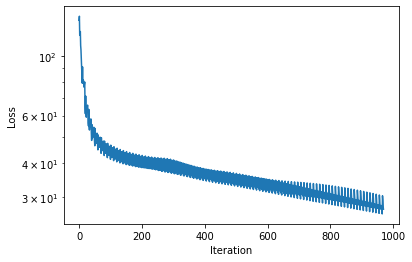

In [31]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

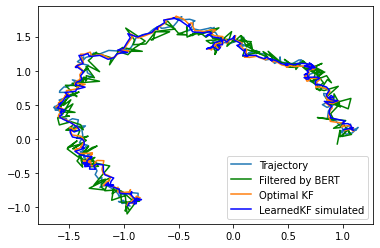

Error between traj and meas 5.008174221995364
Average Squared Error 3.466190117178866
Error between filtered and meas 2.6408630910881707


In [35]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
ind_to_vis = 19

filtered = bert_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
#linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linebert, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by BERT', color='g')
linetrueKF, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Optimal KF")
linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated", color='b')

plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test)
print('Average Squared Error', np.linalg.norm(filtered - traj_test)**2 / num_traj_test)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test)